
# Image Retraining

主要是做练习时候的一个困惑： 

使用已经训练好的 InceptionV3，对新的图片分类问题进行训练，**很容易** 产生过拟合：对训练集，很容易达到100%的准确率，但是对测试集/验证集，准确率不到 50%，并且很难继续提升。 这说明什么，说明确实学习到了图片的特征，但是学习能力太强，产生了过拟合。

google了一下，有些参考：

- https://stackoverflow.com/questions/37605611/would-adding-dropout-help-reduce-overfitting-when-following-tensorflows-transfe

- [Image Retraining](https://www.tensorflow.org/tutorials/image_retraining)

- [tensorboard](https://www.youtube.com/watch?time_continue=1426&v=eBbEDRsCmv4) ，这个视频说了tensorboard的一些特性。例子里面用了不少 summary，用于观察

这里按照 Image Retraining的教程，推演一遍，看看如何解决这个问题

main函数步骤：

1. 准备一些模型参数
2. 准备图片文件，包括训练集、验证集、测试集，以及标签
3. 准备模型
    1. 加载inception_v3模型
    2. 在原模型的某一层（bottleneck）后面添加 新的模型层（ retrain ），用于新的分类任务
    3. 在原模型的前面加上 `jepg_decoding`层，用于jpeg图片的解码。或者加上 `distortion`层，用于data argumentation。
    4. 如果不是用`distortion`，则计算并缓存所有图片在原模型上bottleneck层的输出
    5. 在新的训练层之后添加 评估计算（`add_evaluation_step`）。
4. 训练模型：使用 bottleneck层输出的缓存或者直接计算，以及其他信息，开始训练。
5. 其他操作：存储模型


一些Tips：

1. 需要缓存一些bottleneck输出，最好缓存在服务器上，而不是本地。 这样训练的时候取batch速度会快一些。训练会变快，很有效！
2. 还是不理解tensorflow的session和graph。 在session运行完之后，不能清除GPU内存，非常不方便！
3. 原文件的做法是 将训练后的模型彻底保存下来，然后读取，然后在测试集上评估。
4. 对于tensorflow的placeholder，有没有什么不赋值就用默认值的用法？ 有 `placeholder_with_default`
5. 使用dropout提升的效果并不明显。 一些观察：准确率评估不是很稳定。 后续可以尝试一下 data argumentation。


In [1]:
import os
import re
import hashlib
import sys
import urllib
import tarfile
import random

import numpy as np
import tensorflow as tf
import keras.backend as K

from datetime import datetime
from tensorflow.python.util import compat
from tensorflow.python.platform import gfile

def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
    
limit_mem()


/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. 模型参数

In [2]:
# model_info
model_info =  {
    'data_url': 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz',
    'resized_input_tensor_name': 'Mul:0',
    'bottleneck_tensor_name': 'pool_3/_reshape:0',
    'bottleneck_tensor_size': 2048,
    'class_count': 5,   # class of new task
    'input_width': 299,
    'input_height': 299,
    'input_depth': 3,
    'model_file_name': 'classify_image_graph_def.pb',
    'input_mean': 128,
    'input_std': 128,
    'quantize_layer': False,
}

# configs
class FLAGS:
    model_dir = '/home/yangdong/Downloads/tmp/imagenet/'
    bottleneck_dir = '/tmp/bottleneck/'
    summaries_dir  = '/tmp/retrain_logs'
    final_tensor_name = 'final_result'
    learning_rate = 0.01
    how_many_training_steps = 4000
    eval_step_interval = 100
    train_batch_size = 100
    validation_batch_size = 100
    test_batch_size = -1

CHECKPOINT_NAME = '/tmp/_retrain_checkpoint'

## 2. 准备训练数据

这里是 flower_photos数据，包括5个目录： (daisy  dandelion  roses  sunflowers  tulips)，表示5个分类。每个分类下面一些图片（jpg格式）。

准备训练集、验证集和测试集以及标签。


In [3]:
MAX_NUM_IMAGES_PER_CLASS = 2 ** 27 - 1  # ~134M

image_dir = './flower_photos'


def create_image_lists(image_dir, testing_percentage=10, validation_percentage=10):
    if not gfile.Exists(image_dir):
        tf.logging.error("Image directory '" + image_dir + "' not found.")
        return None
    result = {}
    sub_dirs = [x[0] for x in gfile.Walk(image_dir)]
    # The root directory comes first, so skip it.
    is_root_dir = True
    for sub_dir in sub_dirs:
        if is_root_dir:
            is_root_dir = False
            continue
        extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']
        file_list = []
        dir_name = os.path.basename(sub_dir)
        if dir_name == image_dir:
            continue
        tf.logging.info("Looking for images in '" + dir_name + "'")
        for extension in extensions:
            file_glob = os.path.join(image_dir, dir_name, '*.' + extension)
            file_list.extend(gfile.Glob(file_glob))
        if not file_list:
            tf.logging.warning('No files found')
            continue
        if len(file_list) < 20:
            tf.logging.warning(
                'WARNING: Folder has less than 20 images, which may cause issues.')
        elif len(file_list) > MAX_NUM_IMAGES_PER_CLASS:
            tf.logging.warning(
                'WARNING: Folder {} has more than {} images. Some images will '
                'never be selected.'.format(dir_name, MAX_NUM_IMAGES_PER_CLASS))
        label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
        training_images = []
        testing_images = []
        validation_images = []
        for file_name in file_list:
            base_name = os.path.basename(file_name)
            # We want to ignore anything after '_nohash_' in the file name when
            # deciding which set to put an image in, the data set creator has a way of
            # grouping photos that are close variations of each other. For example
            # this is used in the plant disease data set to group multiple pictures of
            # the same leaf.
            hash_name = re.sub(r'_nohash_.*$', '', file_name)
            # This looks a bit magical, but we need to decide whether this file should
            # go into the training, testing, or validation sets, and we want to keep
            # existing files in the same set even if more files are subsequently
            # added.
            # To do that, we need a stable way of deciding based on just the file name
            # itself, so we do a hash of that and then use that to generate a
            # probability value that we use to assign it.
            hash_name_hashed = hashlib.sha1(compat.as_bytes(hash_name)).hexdigest()
            percentage_hash = ((int(hash_name_hashed, 16) %
                                (MAX_NUM_IMAGES_PER_CLASS + 1)) *
                               (100.0 / MAX_NUM_IMAGES_PER_CLASS))
            if percentage_hash < validation_percentage:
                validation_images.append(base_name)
            elif percentage_hash < (testing_percentage + validation_percentage):
                testing_images.append(base_name)
            else:
                training_images.append(base_name)
        result[label_name] = {
            'dir': dir_name,
            'training': training_images,
            'testing': testing_images,
            'validation': validation_images,
        }
    return result

image_lists = create_image_lists(image_dir)

INFO:tensorflow:Looking for images in 'roses'
INFO:tensorflow:Looking for images in 'sunflowers'
INFO:tensorflow:Looking for images in 'daisy'
INFO:tensorflow:Looking for images in 'dandelion'
INFO:tensorflow:Looking for images in 'tulips'


In [4]:

# class ImageListsHelper(object):
#     def __init__(self, image_lists):
#         self.image_lists = image_lists
#         class_names = image_lists.keys()
#         class_count = len(class_names)
#         self.category_list = ['training', 'testing', 'validation']
        
#     def 

In [5]:

for image_class in image_lists:
    images = image_lists[image_class]
    print(images['dir'], len(images['training']), len(images['testing']), len(images['validation']))

roses 520 66 55
sunflowers 563 65 71
daisy 509 69 55
dandelion 696 98 104
tulips 659 71 69


## 3. 准备模型

### 3.1 使用 inception_v3模型

tensorflow的model文件，参考这个文章： <https://www.tensorflow.org/extend/tool_developers/>

In [6]:

# 下载 inception_v3 模型文件 (.pb文件)

data_url = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
model_dir = './tmp/imagenet'
bottleneck_dir = '/tmp/bottleneck'
model_file_name = 'classify_image_graph_def.pb'
summaries_dir = '/tmp/retrain_logs2/'

# 如果没有 './tmp/imagenet' 文件夹则创建
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
filename = data_url.split('/')[-1]
filepath = os.path.join(model_dir, filename)

# 进度条
def _progress(count, block_size, total_size):
    sys.stdout.write('\r>> Downloading %s %.1f%%' %
                     (filename,
                      float(count * block_size) / float(total_size) * 100.0))
    sys.stdout.flush()
    
# 没有文件则下载
if not os.path.exists(filepath):
    filepath, _ = urllib.request.urlretrieve(data_url, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    tf.logging.info('Successfully downloaded %s %d bytes.', filename, statinfo.st_size)

# 没有模型文件，则解压缩
model_path = os.path.join(model_dir, model_file_name)
if not os.path.exists(model_path):
    print('Extracting file from ', filepath)
    tarfile.open(filepath, 'r:gz').extractall(model_dir)
    

In [7]:

# 从pb文件里面，创建 graph：
print('Model path: ', model_path)

def create_model_graph():
    tf.reset_default_graph()
    with tf.Graph().as_default() as graph:
        print(graph)
        with gfile.FastGFile(model_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            bottleneck_tensor, resized_input_tensor = (tf.import_graph_def(
                graph_def,
                name='',
                return_elements=['pool_3/_reshape:0', 'Mul:0']
            ))
    return graph, bottleneck_tensor, resized_input_tensor

graph, bottleneck_tensor, resized_input_tensor =  create_model_graph()

Model path:  ./tmp/imagenet/classify_image_graph_def.pb


In [8]:
graph

In [9]:
print(resized_input_tensor)
print(bottleneck_tensor)

Tensor("Mul:0", shape=(1, 299, 299, 3), dtype=float32)
Tensor("pool_3/_reshape:0", shape=(1, 2048), dtype=float32)


### 3.2 添加新的训练层

In [10]:

bottleneck_tensor_size = int(bottleneck_tensor.shape[-1])
class_count = len(image_lists)

In [11]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

with graph.as_default():
    # BottleneckInputPlaceholder, input =  bottlenck output
    with tf.name_scope('input'):
        bottleneck_input = tf.placeholder_with_default(
            bottleneck_tensor,
            shape=[None, bottleneck_tensor_size],
            name='BottleneckInputPlaceholder')

        ground_truth_input = tf.placeholder(
            tf.int64, [None], name='GroundTruthInput')

    # Organizing the following ops so they are easier to see in TensorBoard.
    with tf.name_scope('final_retrain_ops'):
        with tf.name_scope('weights'):
            initial_value = tf.truncated_normal(
                [bottleneck_tensor_size, class_count], stddev=0.001)
            layer_weights = tf.Variable(initial_value, name='final_weights')
            variable_summaries(layer_weights)

        with tf.name_scope('biases'):
            layer_biases = tf.Variable(tf.zeros([class_count]), name='final_biases')
            variable_summaries(layer_biases)
            
        # add dropout
        with tf.name_scope('dropout'):
            keep_prob = tf.placeholder_with_default(tf.constant(1.0), [], name='keep_prob')
            drop = tf.nn.dropout(bottleneck_input, keep_prob)
            
        with tf.name_scope('Wx_plus_b'):
            logits = tf.matmul(drop, layer_weights) + layer_biases
            tf.summary.histogram('pre_activations', logits)

    # final output
    final_tensor = tf.nn.softmax(logits, name='final_result')
    tf.summary.histogram('activations', final_tensor)
    
# here we have : (train_step, cross_entropy_mean, bottleneck_input, ground_truth_input, final_tensor)


In [12]:
tf.constant(1.0).shape

TensorShape([])

In [13]:
# cross entropy 和 train：
with graph.as_default():
    # cross entropy
    with tf.name_scope('cross_entropy'):
        cross_entropy_mean = tf.losses.sparse_softmax_cross_entropy(
            labels=ground_truth_input, logits=logits)
    tf.summary.scalar('cross_entropy', cross_entropy_mean)

    # train step, optimizer
    with tf.name_scope('train'):
        optimizer = tf.train.GradientDescentOptimizer(FLAGS.learning_rate)
        train_step = optimizer.minimize(cross_entropy_mean)

In [14]:
# 评估层
with graph.as_default():
    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            prediction = tf.argmax(final_tensor, 1)
            correct_prediction = tf.equal(prediction, ground_truth_input)
        with tf.name_scope('accuracy'):
            evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', evaluation_step)


### 3.3 在原模型前面加上 `jepg_decoding` 层，用于处理图片输入



In [15]:
# 在输入层添加 jpeg decoding层

input_width = 299
input_height = 299
input_depth = 3
input_mean = 128   # 256/2
input_std = 128    # 256/2
# resize and normalize ~(-0.5, 0.5)

with graph.as_default():
    jpeg_data_tensor = tf.placeholder(tf.string, name='DecodeJPGInput')
    decoded_image = tf.image.decode_jpeg(jpeg_data_tensor, channels=input_depth)
    decoded_image_as_float = tf.cast(decoded_image, dtype=tf.float32)
    decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
    resize_shape = tf.stack([input_height, input_width])
    resize_shape_as_int = tf.cast(resize_shape, dtype=tf.int32)
    resized_image = tf.image.resize_bilinear(decoded_image_4d,
                                             resize_shape_as_int)
    offset_image = tf.subtract(resized_image, input_mean)
    decoded_image_tensor = tf.multiply(offset_image, 1.0 / input_std)
    


In [16]:
jpeg_data_tensor.graph

### 3.4 计算并缓存 bottleneck 的输出（对所有图片）


In [17]:
# 计算 bottleneck层 的输出，并缓存。 主要是为了避免重复计算，加快训练速度

def ensure_dir_exists(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    
def run_bottleneck_on_image(sess, image_data):
    # image_data_tensor -> decoded_image_tensor | resized_input_tensor -> bottleneck_tensor
    # image_data -> resized_input_values -> bottleneck_values
    resized_input_values = sess.run(decoded_image_tensor, {jpeg_data_tensor: image_data})
    # Then run it through the recognition network.
    bottleneck_values = sess.run(bottleneck_tensor, {resized_input_tensor: resized_input_values})
    bottleneck_values = np.squeeze(bottleneck_values)
    return bottleneck_values

def create_bottleneck_file(sess, image_path, bottleneck_path):
    if not gfile.Exists(image_path):
        tf.logging.fatal('File does not exist %s', image_path)
    image_data = gfile.FastGFile(image_path, 'rb').read()
    try:
        bottleneck_values = run_bottleneck_on_image(sess, image_data)
    except Exception as e:
        raise RuntimeError('Error during processing file %s (%s)' % (image_path, str(e)))
        
    bottleneck_string = ','.join(str(x) for x in bottleneck_values)
    with open(bottleneck_path, 'w') as bottleneck_file:
        bottleneck_file.write(bottleneck_string)

ensure_dir_exists(bottleneck_dir)
def get_or_create_bottleneck(sess, label_name, image_name):
    image_path = os.path.join(image_dir, label_name, image_name)
    bottleneck_path = os.path.join(bottleneck_dir, label_name, image_name + '.txt')
    
    if not os.path.exists(bottleneck_path):
        create_bottleneck_file(sess, image_path, bottleneck_path)
    with open(bottleneck_path, 'r') as bottleneck_file:
        bottleneck_string = bottleneck_file.read()
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
    return bottleneck_values
    
    
def cache_bottlenecks(sess):
    how_many_bottlenecks = 0
    for label_name, label_lists in image_lists.items():
        sub_dir = os.path.join(bottleneck_dir, label_name)
        ensure_dir_exists(sub_dir)
        for category in ['training', 'testing', 'validation']:
            category_list = label_lists[category]
            for index, unused_base_name in enumerate(category_list):
                get_or_create_bottleneck(sess, label_name, unused_base_name)
                how_many_bottlenecks += 1
#                 if how_many_bottlenecks % 100 == 0:
#                     tf.logging.info(str(how_many_bottlenecks) + ' bottleneck files created.')
                    



## 4. 开始训练



In [18]:
# 定义batch 方法：

def get_random_cached_bottlenecks(sess, batch_size, category):
    """Retrieves bottleneck values for cached images.
    Args:
      category: training, testing, or validation.
    Returns:
      List of bottleneck arrays, their corresponding ground truths, and the
      relevant filenames.
    """
    class_count = len(image_lists.keys())
    bottlenecks = []
    ground_truths = []
    filenames = []
    if batch_size >= 0:
        for unused_i in range(batch_size):
            # random label
            label_index = random.randrange(class_count)
            label_name = label_name = list(image_lists.keys())[label_index]
            image_list = image_lists[label_name][category]
            image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1) % len(image_list)
            image_name = image_list[image_index]
            bottleneck = get_or_create_bottleneck(sess, label_name, image_name)
            bottlenecks.append(bottleneck)
            ground_truths.append(label_index)
            filenames.append(image_name)
    else:
        # Retrieve all bottlenecks.
        for label_index, label_name in enumerate(image_lists.keys()):
            for image_index, image_name in enumerate(image_lists[label_name][category]):
                bottleneck = get_or_create_bottleneck(sess, label_name, image_name)
                bottlenecks.append(bottleneck)
                ground_truths.append(label_index)
                filenames.append(image_name)
                
    return bottlenecks, ground_truths, filenames


In [19]:
# sess = tf.InteractiveSession(graph=graph)

# summaries_dir = '/tmp/retrain_logs2/'

# with tf.Session(graph=graph) as sess:
    


In [20]:
summaries_dir = '/tmp/retrain_logs2/'

In [21]:
training_steps= 4000
dropout_keep_prob = 0.5

with tf.Session(graph=graph) as sess:
    # cache bottlenecks
    cache_bottlenecks(sess)

    # summary
    merged = tf.summary.merge_all()

    train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
    validation_writer = tf.summary.FileWriter(FLAGS.summaries_dir + '/validation')
    train_saver = tf.train.Saver()

    # 
    # Set up all our weights to their initial default values.
    init = tf.global_variables_initializer()
    sess.run(init)
    # Run the training for as many cycles as requested on the command line.
    for i in range(training_steps):
        (train_bottlenecks, train_ground_truth, _) = get_random_cached_bottlenecks(
                sess, FLAGS.train_batch_size, 'training')
        # Feed the bottlenecks and ground truth into the graph, and run a training
        # step. Capture training summaries for TensorBoard with the `merged` op.
        train_summary, _ = sess.run(
            [merged, train_step],
            feed_dict={
                bottleneck_input: train_bottlenecks,
                ground_truth_input: train_ground_truth,
                keep_prob: dropout_keep_prob,
            })
        train_writer.add_summary(train_summary, i)

        # Every so often, print out how well the graph is training.
        is_last_step = (i + 1 == training_steps)
        if (i % FLAGS.eval_step_interval) == 0 or is_last_step:
            train_accuracy, cross_entropy_value = sess.run(
                [evaluation_step, cross_entropy_mean],
                feed_dict={
                    bottleneck_input: train_bottlenecks,
                    ground_truth_input: train_ground_truth
                })
            tf.logging.info('%s: Step %d: Cross entropy = %f, Train accuracy = %.1f%%' % (
                datetime.now(), i, cross_entropy_value, train_accuracy * 100))
            
            validation_bottlenecks, validation_ground_truth, _ = (
                get_random_cached_bottlenecks(sess, FLAGS.validation_batch_size, 'validation'))

            # Run a validation step and capture training summaries for TensorBoard
            # with the `merged` op.
            validation_summary, validation_accuracy = sess.run(
                [merged, evaluation_step],
                feed_dict={
                    bottleneck_input: validation_bottlenecks,
                    ground_truth_input: validation_ground_truth
                })
            validation_writer.add_summary(validation_summary, i)
            tf.logging.info('%s: Step %d: Validation accuracy = %.1f%% (N=%d)' %
                            (datetime.now(), i, validation_accuracy * 100,
                             len(validation_bottlenecks)))
    # 这个用于保存session中的模型和参数信息
    #     train_saver.save(sess, CHECKPOINT_NAME)

    #     # We've completed all our training, so run a final test evaluation on
    #     # some new images we haven't used before.
    test_bottlenecks, test_ground_truth, test_filenames = (
        get_random_cached_bottlenecks(sess, FLAGS.test_batch_size, 'testing'))
        
    test_accuracy, predictions = sess.run(
        [evaluation_step, prediction],
        feed_dict={
            bottleneck_input: test_bottlenecks,
            ground_truth_input: test_ground_truth
        })
    tf.logging.info('Final test accuracy = %.1f%% (N=%d)' %
                    (test_accuracy * 100, len(test_bottlenecks)))

INFO:tensorflow:2018-03-21 09:40:07.284301: Step 0: Cross entropy = 1.493493, Train accuracy = 42.0%
INFO:tensorflow:2018-03-21 09:40:07.445964: Step 0: Validation accuracy = 27.0% (N=100)
INFO:tensorflow:2018-03-21 09:40:11.194423: Step 100: Cross entropy = 0.592498, Train accuracy = 90.0%
INFO:tensorflow:2018-03-21 09:40:11.232532: Step 100: Validation accuracy = 86.0% (N=100)
INFO:tensorflow:2018-03-21 09:40:14.962611: Step 200: Cross entropy = 0.517569, Train accuracy = 85.0%
INFO:tensorflow:2018-03-21 09:40:15.000458: Step 200: Validation accuracy = 90.0% (N=100)
INFO:tensorflow:2018-03-21 09:40:18.729574: Step 300: Cross entropy = 0.389623, Train accuracy = 90.0%
INFO:tensorflow:2018-03-21 09:40:18.767550: Step 300: Validation accuracy = 87.0% (N=100)
INFO:tensorflow:2018-03-21 09:40:22.498789: Step 400: Cross entropy = 0.357378, Train accuracy = 92.0%
INFO:tensorflow:2018-03-21 09:40:22.536886: Step 400: Validation accuracy = 84.0% (N=100)
INFO:tensorflow:2018-03-21 09:40:26.265



没有 Dropout的时候： INFO:tensorflow:Final test accuracy = 91.6% (N=369)

加了一层dropout训练（keep_prob=0.8)： INFO:tensorflow:Final test accuracy = 91.9% (N=369)

提升了一点点。。

keep_prob=0.5： INFO:tensorflow:Final test accuracy = 92.7% (N=369)
略有提升

将learning rate 从0.01改成0.001， Final test accuracy = 88.1% (N=369)  ， 会下降。

## 5. error analysis

就是好奇，什么样的图片分类会错误。



In [41]:

error_files = []
label_names = list(image_lists.keys())

for i, pred in enumerate(predictions):
    label = test_ground_truth[i]
    if pred != label:
        filename = test_filenames[i]
        image_path = os.path.join(image_dir, label_names[label], filename)
        error_files.append((image_path, label_names[label], label_names[pred]))

In [33]:
1 - len(error_files) / len(test_filenames)

0.924119241192412

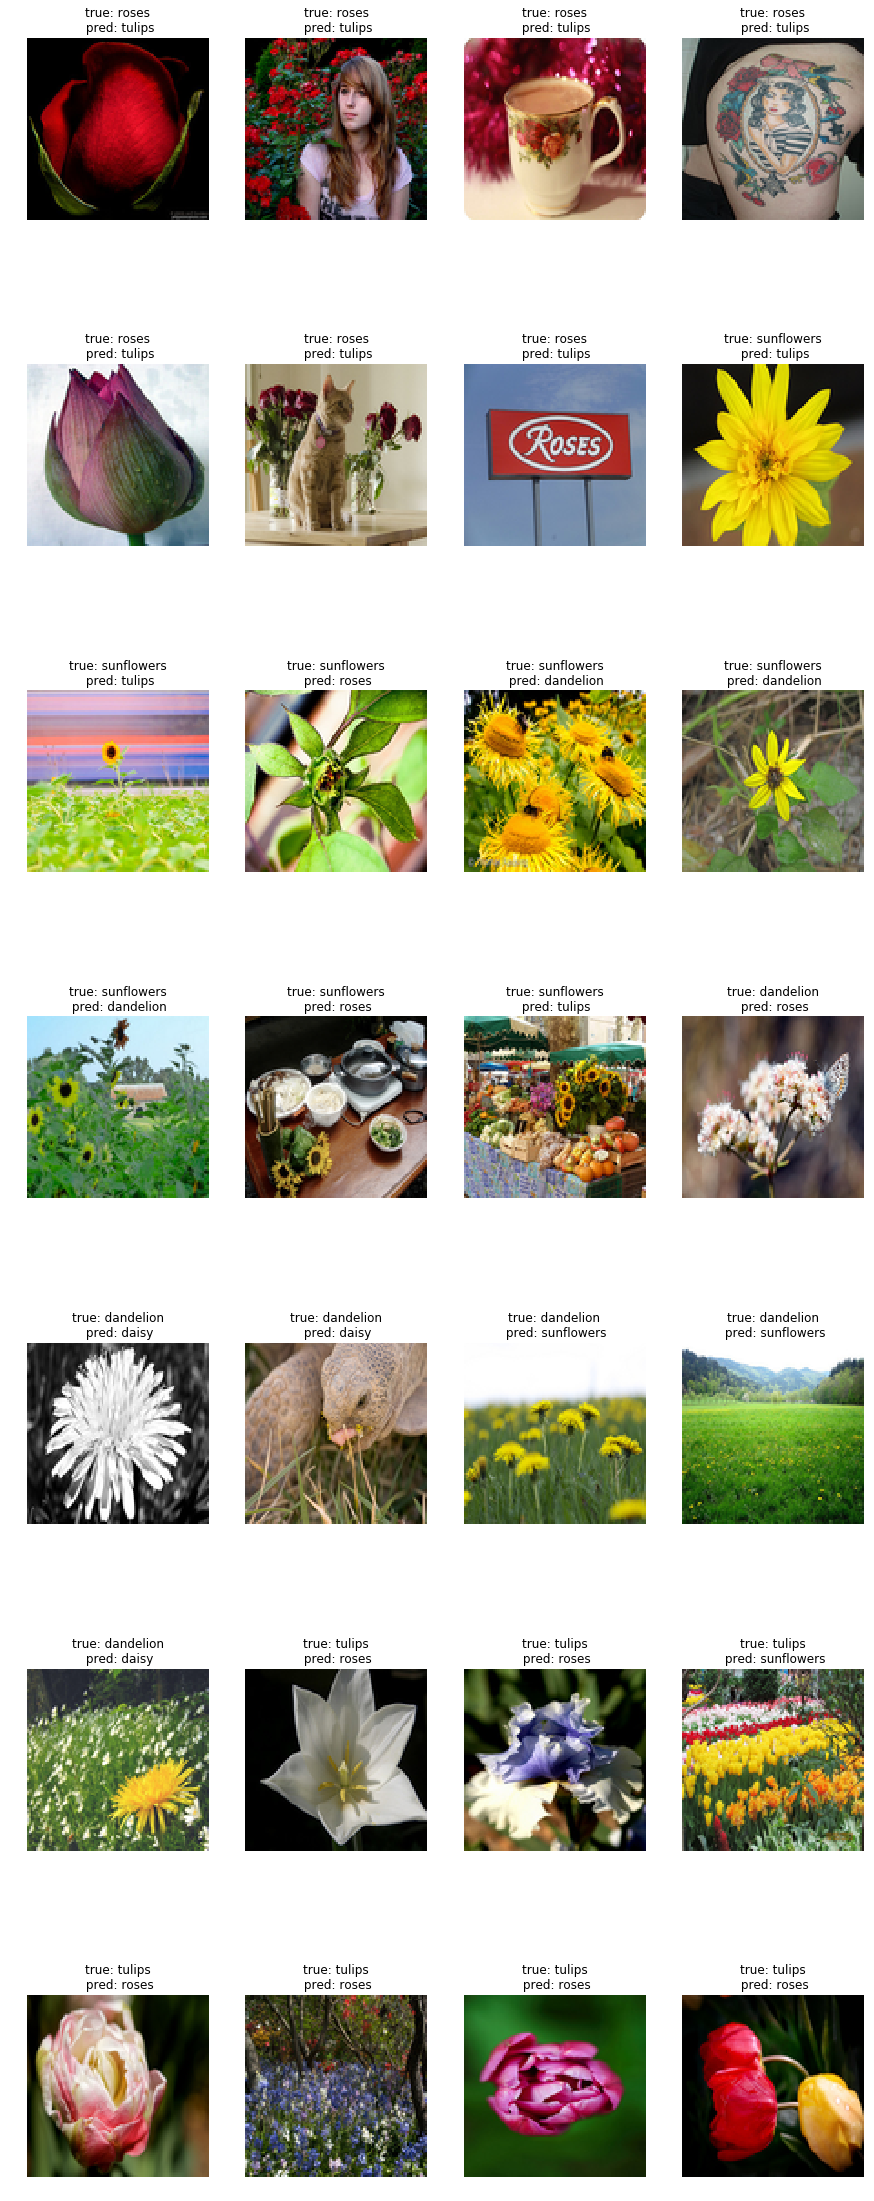

In [80]:

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# inspect preditions
cols = 4
rows = 7
fig = plt.figure(figsize=(4 * cols - 1, 6 * rows - 1))

for i, (filename, label, pred) in enumerate(error_files):
    c = i % cols
    r = i // cols
    ax = fig.add_subplot(rows, cols, i+1)
    ax.grid(False)
    ax.axis('off')
    image = Image.open(filename)
    # can use crop here
    image = image.resize((100, 100), Image.ANTIALIAS)
    ax.imshow(np.asarray(image))
    ax.set_title("true: {}\n pred: {}".format(label, pred))
plt.show()

# roses：玫瑰
# tulips：郁金香
# sunflowers： 向日葵
# dandelion： 蒲公英
# daisy： 雏菊



有些我也分辨不出来。。。更扯的是居然有个 roses的文字广告牌。。。 我估计这个CNN怎么也识别不出来。 而且训练图片也是很乱。